In [203]:
from time import sleep
import numpy as np
import urllib3
import matplotlib
from numpy import append
import config
import vectorbt as vbt
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from alpaca_trade_api.rest import REST
import gym
import gym_anytrading
from tensorflow.keras.models import load_model
import requests

from stable_baselines import ACKTR
from stable_baselines.common.evaluation import evaluate_policy

- TRY=X: No data found for this date range, symbol may be delisted


0

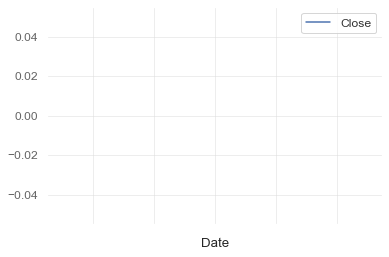

In [204]:
data = vbt.YFData.download(symbols= 'TRY=X', period="119d")
#df = vbt.Portfolio.from_holding(data, init_cash=100)
#print(data.data['TRYUSD=X']['Close'])
X=data.data['TRY=X'].index
Y=data.data['TRY=X'].Close
data.data['TRY=X'].reset_index().plot(x='Date', y='Close')
X=data.data['TRY=X']
liraDF = pd.DataFrame( X['Close'])
LiraArray = np.array(liraDF)
liraDF.size

In [205]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
testingSet = pd.DataFrame(liraDF)
testing_set_scaled = sc.fit_transform(testingSet)
testing_set_scaled

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
inputs = liraDF[0:].values     #lstm input shape edit
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60,liraDF.size):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], 1))
#X_test = np.reshape(X_test, (int(X_test.size/60), 60,1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

C:\Users\90507\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_test

array([[[0.06011408],
        [0.03958633],
        [0.        ],
        ...,
        [0.522676  ],
        [0.53370724],
        [0.54069204]],

       [[0.03958633],
        [0.        ],
        [0.04028206],
        ...,
        [0.53370724],
        [0.54069204],
        [0.56442671]],

       [[0.        ],
        [0.04028206],
        [0.06898358],
        ...,
        [0.54069204],
        [0.56442671],
        [0.63171643]],

       ...,

       [[0.50439034],
        [0.522676  ],
        [0.53370724],
        ...,
        [0.97530368],
        [0.97838002],
        [0.97926713]],

       [[0.522676  ],
        [0.53370724],
        [0.54069204],
        ...,
        [0.97838002],
        [0.97926713],
        [0.98755457]],

       [[0.53370724],
        [0.54069204],
        [0.56442671],
        ...,
        [0.97926713],
        [0.98755457],
        [0.99506645]]])

In [ ]:
lira_model = load_model('Lira_BOT.bot')
predicted_close_value = lira_model.predict(X_test)
predicted_close_value = sc.inverse_transform(predicted_close_value)

In [ ]:
predicted_close_value = pd.DataFrame(predicted_close_value)
predicted_close_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       59 non-null     float32
dtypes: float32(1)
memory usage: 364.0 bytes


In [ ]:
from scipy.stats import pearsonr
from pingouin import corr
from researchpy.correlation import corr_case

In [ ]:
predictions_TRY = predicted_close_value
%store -r predictions_SOL2

In [ ]:
predictions_all = np.array([predictions_TRY,predictions_SOL2])

In [ ]:
print(predictions_all[0][0:5])
print(predictions_all[1][0:5])
change_try = np.zeros(predictions_all[0].size-1)
change_sol = np.zeros(predictions_all[0].size-1)

[[16.521297]
 [16.56109 ]
 [16.61561 ]
 [16.707985]
 [16.837477]]
[[3.682153 ]
 [3.6880589]
 [3.705544 ]
 [3.698739 ]
 [3.7075028]]


In [ ]:
for i in range(1,len(predictions_all[0])):
    change_try[i-1] = 100 * (predictions_all[0][i] - predictions_all[0][i-1]) / predictions_all[0][i-1]
    change_sol[i-1] = 100 * (predictions_all[1][i] - predictions_all[1][i-1]) / predictions_all[1][i-1]

In [ ]:
print(change_try[-5:]," *** " ,predictions_all[0][-5:])
print(change_sol[-5:]," *** ",predictions_all[1][-5:])

[0.0623294  0.1265578  0.16217518 0.17486602 0.17337185]  ***  [[18.044472]
 [18.067308]
 [18.09661 ]
 [18.128254]
 [18.159683]]
[ 0.26228112 -0.44130242  0.62537724  0.29105502  0.08881132]  ***  [[3.8114889]
 [3.7946687]
 [3.8183997]
 [3.8295133]
 [3.8329144]]


In [ ]:
print(change_sol.size," *** ",predictions_all[1].size)

58  ***  59


In [ ]:
predictions_all[0] = predictions_all[0] * 0.488 * 0.71 / 1.56
predictions_all[1] = predictions_all[1] * 0.369 * 0.86 / 1.56

In [ ]:
changes_all = np.array([change_try, change_sol])
print(changes_all[0][0]," *** ",changes_all[1][0])

0.24085889756679535  ***  0.1603916734457016


In [ ]:
latest_eth = vbt.YFData.download(symbols= 'ETH-USD', period="60d").get('Close')

In [ ]:
gas_dummy = pd.read_csv("AvgGasPrice.csv")
gas_dummy = gas_dummy[-59:].reset_index()
gas_prices = np.array(gas_dummy["Value (Wei)"])
gas_prices = np.append(gas_prices,gas_prices[-1])
gas_prices = gas_prices * 10e-10
gas_prices = gas_prices * 21000 
gas_prices = gas_prices * 10e-10
gas_prices[-3:]

array([0.000439  , 0.00038022, 0.00038022])

In [ ]:
buy_sel_signal = np.array([])
one_hundred_dollar = (100 + gas_prices[0] * latest_eth[0]) / latest_eth[0]
for i in range(len(changes_all[0])):
    one_hundred_dollar = (100+gas_prices[i] * latest_eth[i]) / latest_eth[i]
    if(changes_all[0][i] * changes_all[1][0] > 0):
        if(np.abs((changes_all[0][i] + changes_all[1][i])/2) >= one_hundred_dollar):
            if(changes_all[0][i] < 0):
                buy_sel_signal = np.append(buy_sel_signal, -1)
            else:
                buy_sel_signal = np.append(buy_sel_signal, 1)
        else:
            buy_sel_signal = np.append(buy_sel_signal, 0)
    else:
        buy_sel_signal = np.append(buy_sel_signal,0)

In [ ]:
total_eth = 10000 / latest_eth[0]
total_money = 10000
position = []
for i in range(len(buy_sel_signal)):
    if buy_sel_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
    
for i in range(len(buy_sel_signal)):
    if buy_sel_signal[i] == 0 :
        position[i] = 1
    elif buy_sel_signal[i] == -1  or buy_sel_signal[i] == 1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [ ]:
total_records = np.array([buy_sel_signal,buy_sel_signal])
for i in range(len(buy_sel_signal)):
    total_records[0][i] = total_money
    total_records[1][i] = total_eth
    one_hundred_dollar = (100+gas_prices[i] * latest_eth[i]) / latest_eth[i]
    if(buy_sel_signal[i]!=0 and position[i]!=1):
        if(buy_sel_signal[i]==1):
            total_eth +=  one_hundred_dollar
            total_money = total_money - 100 - gas_prices[i] * latest_eth[i] - 0.001*(100 + gas_prices[i] * latest_eth[i])
        elif(buy_sel_signal[i]==-1):
            total_eth -=  one_hundred_dollar
            total_money = total_money + 100 - gas_prices[i] * latest_eth[i] - 0.001*(100 + gas_prices[i] * latest_eth[i])

In [ ]:
print(total_money," *** ",total_eth * latest_eth[-1])
print(" ***** ")
print(total_records[0][4:8], " *** ", total_records[1][4:8])

5967.938844513569  ***  17518.824921599135
 ***** 
[9595.64391587 9495.0659236  9394.31588781 9293.42581229]  ***  [9.47612989 9.56970468 9.65714536 9.74598241]


In [ ]:
print("Starting Money = $10K")
print("Starting Ethereum = ",(10000 / latest_eth[0]),"ETH")
print("Last Total Money = ", total_money+(total_eth*latest_eth[-1]))
profit = 100 * (total_money+(total_eth*latest_eth[-1]) -20000) / 20000
print("Profit = %",profit)

Starting Money = $10K
Starting Ethereum =  9.099646011329238 ETH
Last Total Money =  23486.763766112705
Profit = % 17.433818830563524


In [ ]:
control = 0
for i in range(len(buy_sel_signal)):
    #if(buy_sel_signal[i]==1):
        #print("It is a buy order after ",i+1," days")
    if(buy_sel_signal[i]==1):
        control = control + 1
        #print("It is a sell order after ",i+1," days")
    #dollar_100 = (100+gas_prices[i] * latest_eth[i]) / latest_eth[i]
    #print(np.abs((changes_all[0][i] + changes_all[1][i])/2)," *** ",dollar_100)
    #print(changes_all[0][i] ," *** ", changes_all[1][i]," *** ",dollar_100)
print(control)

40


In [ ]:
for i in range(change_try.size):
    if(change_try[i]<0):
        print(change_try[i]," *** ",change_sol[i])